<a href="https://colab.research.google.com/github/DonErnesto/amld2020-unsupervised/blob/master/notebooks/exercises_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise: Demonstration of several algorithms on the Pen Digits dataset

Exercises using the Pen Digits Dataset: https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/literature/PenDigits/PenDigits_v01.html

The data is already present in .pkl format (load the data below).
This data set was created by recording the writing pattern of digits on a digital writing pad. The digit "4" is downsampled to only 20 instances, making it an outlier. 

Note that (unlike MNIST), the features do not simply correspond to pixels, but are subsampled coordinates, 8 pairs. 

This dataset is small and simple: it has only numeric features and no NaN's. 

# Package installing and data import

In [5]:
# Clode git repository for access to Outlierutils and input data files
!git clone https://github.com/DonErnesto/amld2020-unsupervised.git

fatal: destination path 'amld2020-unsupervised' already exists and is not an empty directory.


In [8]:
# Install pyod package
!pip install pyod

## Imports 

In [0]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale as preproc_scale
from sklearn.manifold import TSNE

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.iforest import IForest



In [0]:
sys.path.append("./amld2020-unsupervised/") #to enable importing from outlierutils
from outlierutils import plot_top_N, plot_outlier_scores # For easy plotting and evaluation

## Data loading

In [0]:
data_path = './amld2020-unsupervised/data/'
x_pen = pd.read_pickle(os.path.join(data_path, 'x_pendigits.pkl'))
y_pen = pd.read_pickle(os.path.join(data_path, 'y_pendigits.pkl'))

# Scale and put again into a DataFrame
sc = StandardScaler()
x_pen = pd.DataFrame(data=sc.fit_transform(x_pen))

In [12]:
print('Number of points: {}'.format(len(y_pen)))
print('Number of positives: {} ({:.3%})'.format(y_pen.sum(), y_pen.mean()))

Number of points: 9868
Number of positives: 20 (0.203%)


## Demo: Usage of plotting functions

See examples how to plot the conditional scores and the top-N ranking below

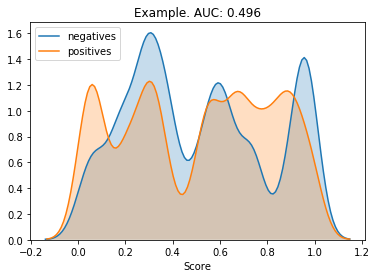

In [13]:
# example with random data
y_true_, scores_ = np.random.choice([0, 1], 100), np.random.uniform(size=100)
results = plot_outlier_scores(y_true=y_true_, 
                            scores=scores_, 
                            bw=0.05, 
                            title='Example.')

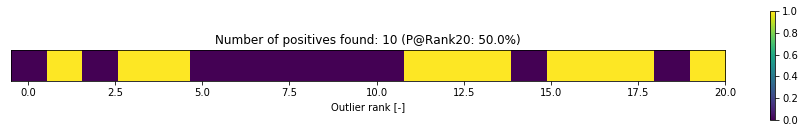

In [14]:
results = plot_top_N(y_true=y_true_, scores=scores_, N=20)

Note that both `plot_outlier_scores` and `plot_top_N` expect numpy arrays. These may be obtained from a pandas Series using `pd.Series.values`


## 0. : Data visualization

t-SNE of large datasets may take a long time to compute. The next piece of code will downsample the negatives, while retaining all positives. 

In [0]:
N_downsample = 3000
assert x_pen.index.equals(y_pen.index), 'Error, indexes differ. Reset them to continue'
x_downsampled = pd.concat((x_pen[y_pen==0].sample(N_downsample - int(y_pen.sum()), random_state=1),
                           x_pen[y_pen==1]), 
                          axis=0).sample(frac=1, random_state=1)
y_downsampled = y_pen[x_downsampled.index]


Q 0. Reduce the dimensionality with T-SNE, and visualize the positive and negative class in a scatter plot. 
What do you observe?

**Hint**: To get the correct arguments of TSNE, run `?TSNE`  

In [0]:
?TSNE

In [0]:
MAX_N_TSNE = 4000 #Avoid overly long computation times with TSNE. Values < 4000 recommended 
neg = y_downsampled == 0
pos = y_downsampled == 1

assert len(x_downsampled) <= MAX_N_TSNE, 'Using a dataset with more than {} points is not recommended'.format(
                                            MAX_N_TSNE)
#X_2D = TSNE(xxxx).fit_transform(xxxx) # transform to 2-D space for plotting
#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#ax.scatter(X_2D[pos, 0], X_2D[pos, 1], c=[[0.8, 0.4, 0.4],], marker='x', s=120, label='Positive')
#ax.scatter(X_2D[neg, 0], X_2D[neg, 1], c=[[0.2, 0.3, 0.9],], marker='o', s=10, label='Negative')

#plt.axis('off')
#plt.legend()
#plt.show() 

In [0]:
del x_downsampled, y_downsampled # To avoid using the wrong data later


## 1a. Mahalonobis Distance, single cluster

Using `EmpiricalCovariance`, or `MinCovDet` (a robust estimator), do a `.fit()` to fit the covariance matrix. 
Determine the distance with `.mahalonobis()` and use this as outlier score. Get the Area Under the ROC-Curve and Precision@100 using `plot_outlier_scores` and `plot_top_N`

In [0]:
# cov_ = EmpiricalCovariance().fit(x_pen)


## 1b. Mahalonobis Distance, GMM

Using `GaussianMixture`, with a reasonable value for n_components and `covariance_type=full`, do a `.fit()` and `.score_samples()` to get the log-probability of each sample. The negative log-probability will be the outlier score.


In [20]:
# gmm = GaussianMixture(n_components=xxxx, covariance_type='full', random_state=1) # try also spherical
# gmm.fit(x_pen)


NameError: ignored

### 2. KNN algorithm


#### Q 2.1 
With the scikit-learn NearestNeighbors class, determine the probability of the nearest neighbour of a point being an outlier, conditional on the class membership of that point. Note how this corresponds to the observations from the t-SNE visualization
 
**HINT**: 
- *The output of clf.kneighbors() (after doing clf.fit()) is a tuple, the first element being an array with distances, the second element being an array with indexes of neighbours. The first column corresponds to the points themselves. The code provided in the next cell may be used to get the indices of the nearest neighbour of all points.*

In [0]:
# clf_nn = NearestNeighbors(n_neighbors=...)
# clf_nn.fit(x_pen)
# nearest_1st_n = clf_nn.kneighbors(x_pen)[1][:, 1] # to get the indices of the first nearest neighbour for each point

## Next, get the conditional mean by subsetting nearest_1st_ns with y_pen==1 or y_pen==0

#### Q 2.2 
Use pyod's KNN class to detect the outliers. 
Use `method=median`, and guess a reasonable value for `n_neighbors`based on the insights from t-SNE and the previous question. 

Plot the conditional score curves and the top-100 results, using `plot_outlier_scores` and `plot_top_N`. 

Vary n_neighbors, how does it affect AUC and precision@100?

**HINT**: 
- *Use clf.decision_scores_ (an attribute of all pyod's detectors) to get the outlier scores (and not the binary labels, that are stored in clf.labels_)*


In [0]:
# clf = KNN(method='median', n_neighbors=xxx)
# clf.fit()
# get the prediction label and outlier scores of the training data
# y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
# y_train_scores = clf.decision_scores_  # raw outlier scores (use these for scoring!)

### 3. LOF algorithm

Note that the LOF algorithm compares the "reachability density" of a point to its k nearest neighbours, compared to that same density of its nearest neighbours.

Also here, we will use a pyod class. Therefore, we can use the same method- and attribute names. 

#### Q 3.1 
Considering the concept that underlies LOF, and the results from the t-SNE/Nearest neighbour analysis, do you expect LOF to do better than KNN with n_neighbours=10? Why?

#### Q 3.2
Plot the scoring curves for a few values of n_neighbours. What is a good value?



In [0]:
# lof = LocalOutlierFactor(n_neighbors=n_neighbours, contamination=0.01)




### 4. Isolation Forest

#### Q 4.1 
What disadvantage of Isolation Forest do you see compared to the previous algorithms?

#### Q 4.2
Run an `IsolationForest`analysis with a reasonable set of parameters


In [0]:
# ifo = IsolationForest(xxx, behaviour='new')
# NB: in contradiction to the documentation, there is no .decision_scores_ attribute for iForest


#### (optional) Q 4.3 
Compare the scatter in AUC scores by running ten times the Isolation Forest, with different `random_state`s, for `n_estimators`=100

### 5. PCA reconstruction error

#### Q 5.1
What number of components would you estimate to be suffificient? How may it be determined?

#### Q 5.2
Determine the Euclidean reconstruction error, by first transforming the data, and then applying the inverse transform.

**Use the sci-kit learn implementation, rather than pyod's PCA class. This one seems not to be implemented well**


In [0]:
# pca = PCA(n_components=...)
# pca_tf = ... 
# x_pen_recon = ...

In [0]:
# pca_recon = ((x_pen - x_pen_recon)**2).mean(axis=1)


### 7. Autoencoder reconstruction error

#### Q 7.1

Run the autoencoder with a bottleneck size that worked well for PCA. Run for ~15 epochs and look at AUC score. 
Many different configurations (number of hidden layers, number of neurons) may be used, but pick one. 



In [0]:
if False:
    clf = AutoEncoder(
        hidden_neurons=[xx, xx, xx],
        hidden_activation='elu',
        output_activation='linear',
        optimizer='adam',
        epochs=15,
        batch_size=16,
        dropout_rate=0.0, #may not be needed here
        l2_regularizer=0.0,
        validation_size=0.1,
        preprocessing=False, #NB: this uses sklearn's StandardScaler
        verbose=1,
        random_state=1,
    )


In [0]:
# clf.fit(x_pen)


#### Q 8 

- Which algorithm performed best?
- Can it be reasonably "tuned" without having the labels available?


#### Q 9

Run the next code, that replaces the original outliers with sythesized ones (combining the first 8 and last 8 features of randomly chosen observations), and run the analysis again. What differences do you observe?


In [0]:
new_values = pd.concat((x_pen.sample(20, random_state=1).iloc[:, :8].reset_index(drop=True),
                        x_pen.sample(20, random_state=2).iloc[:, 8:].reset_index(drop=True)),
                 axis=1).set_index(y_pen[y_pen==1].index)
x_pen.loc[y_pen==1, :] = new_values